In [104]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [105]:
gdf = gpd.read_parquet('Legotization.parquet')
gdf = gdf[['id', 'max_height', 'geometry']]

In [106]:
plates = gpd.read_file('./data/all')
plates = plates[plates['Id']!=3]
plates.rename(columns={'Id': 'plate_id'}, inplace=True)

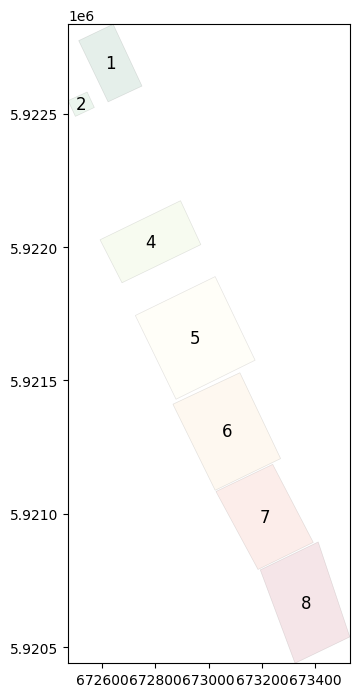

In [107]:
# Creando la figura
fig, ax = plt.subplots(figsize=(11.7, 8.3))  # Tamaño A4 en pulgadas

# Colorear los polígonos
plates.plot(ax=ax, cmap='RdYlGn_r', alpha=0.1, edgecolor='black', linewidth=0.5)
xmin, ymin, xmax, ymax = plates.total_bounds
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
# Anotar con el valor de LEGO
for idx, row in plates.iterrows():
    centroid = row['geometry'].centroid
    plt.annotate(text=row['plate_id'], xy=(centroid.x, centroid.y),
                 horizontalalignment='center', verticalalignment='center', fontsize=12)

In [130]:
# gdf['plate_id'] = 0

# Realizar un spatial join para encontrar cuadrados que intersectan con los polígonos
intersected = gpd.sjoin(gdf, plates, how='inner', op='intersects')

# Calcular la intersección real y agregarla como una nueva geometría
intersection = gpd.overlay(gdf, plates, how='intersection')

# Calcular el área de las intersecciones y del cuadrado original
intersection['intersection_area'] = intersection.area

not_plates_gdf = gdf[~gdf['id'].isin(intersection['id'])]
not_plates_gdf['plate_id'] = 0

concat_gdf = pd.concat([intersection, not_plates_gdf]).drop(columns=['geometry'])
merge_gdf = pd.merge(concat_gdf, gdf[['id', 'geometry']], on='id')
merge_gdf = gpd.GeoDataFrame(data=merge_gdf.drop(columns=['geometry']), geometry=merge_gdf['geometry'])
merge_gdf['area'] = merge_gdf.area
merge_gdf['intersection_area'].fillna(0, inplace=True)
merge_gdf['area_ratio'] = merge_gdf['intersection_area']/merge_gdf['area']
merge_gdf.loc[merge_gdf['area_ratio']<0.75, 'plate_id'] = 0
gdf = merge_gdf.copy()

In [131]:
import numpy as np
from shapely.geometry import Polygon, Point, Polygon, MultiPolygon, LineString, MultiLineString
from shapely.affinity import rotate

def rotate_point(x, y, angle_rad, origin):
    """Rotar un punto alrededor de un origen dado"""
    x_rot = origin[0] + (x - origin[0]) * np.cos(angle_rad) - (y - origin[1]) * np.sin(angle_rad)
    y_rot = origin[1] + (x - origin[0]) * np.sin(angle_rad) + (y - origin[1]) * np.cos(angle_rad)
    return x_rot, y_rot

def rotate_geometry(geom, angle, origin):
    """Rotar una geometría (polígono, línea) alrededor de un origen dado."""
    if geom.type == 'Polygon':
        exterior = [rotate_point(x, y, angle, origin) for x, y in geom.exterior.coords]
        interiors = [[rotate_point(x, y, angle, origin) for x, y in interior.coords] for interior in geom.interiors]
        return Polygon(exterior, interiors)
    elif geom.type == 'MultiPolygon':
        polygons = [rotate_geometry(part, angle, origin) for part in geom.geoms]
        return MultiPolygon(polygons)
    elif geom.type == 'LineString':
        return LineString([rotate_point(x, y, angle, origin) for x, y in geom.coords])
    elif geom.type == 'MultiLineString':
        return MultiLineString([rotate_geometry(part, angle, origin) for part in geom])
    else:
        # Añadir manejo para otros tipos de geometrías si es necesario
        return geom
    
def rotate_gdf(gdf, angle_degrees):
    """Rotar todas las geometrías en un GeoDataFrame."""
    angle_radians = np.radians(angle_degrees)

    # Encontrar el centro de todos los datos
    all_points = [geom.centroid for geom in gdf.geometry]
    all_points = gpd.GeoDataFrame(geometry=all_points)
    all_points['x'] = all_points.geometry.x
    all_points['y'] = all_points.geometry.y
    print()
    
    center = all_points[['x','y']].mean()
    # center = (0, 100)

    # Rotar cada geometría
    rotated_geoms = gdf.geometry.apply(lambda geom: rotate_geometry(geom, angle_radians, center))

    return gpd.GeoDataFrame(gdf[['geometry']], geometry=rotated_geoms)

In [ ]:
angle_degrees = -27.4
rotated_gdf = rotate_gdf(gdf,angle_degrees)
# angle_degrees = 90
# rotated_gdf = rotate_gdf(rotated_gdf,angle_degrees)
gdf.reset_index(inplace=True)
rotated_gdf.reset_index(inplace=True)
rotated_merge_gdf = pd.merge(rotated_gdf, gdf.drop(columns=['geometry']), on='index')

In [134]:
import pandas as pd
import geopandas as gpd

def mapear_a_legos(valor, lego_min, lego_max, min_height, max_height):
    # Reescalar el valor desde el rango original (min_height, max_height)
    # al nuevo rango (lego_min, lego_max)
    return lego_min + (valor - min_height) * (lego_max - lego_min) / (max_height - min_height)

null_gdf = rotated_merge_gdf[rotated_merge_gdf['max_height'].isnull()]
gdf = rotated_merge_gdf.dropna(subset=['max_height'])

# Suponiendo que tu GeoDataFrame se llama 'gdf' y tiene una columna 'max_height'
min_height = gdf['max_height'].min()
max_height = gdf['max_height'].max()
lego_min, lego_max = 1, 20 # Establece tus propios límites para lego_min y lego_max

gdf['LEGO'] = gdf['max_height'].apply(mapear_a_legos, args=(lego_min, lego_max, min_height, max_height))
gdf['LEGO'] = gdf['LEGO'].round().astype(int)  # Redondear a enteros

null_gdf['LEGO'] = 0

gdf = pd.concat([gdf, null_gdf])
gdf = gpd.GeoDataFrame(data=gdf.drop(columns=['geometry']), geometry=gdf['geometry'])

In [136]:
gdf

,index,id,max_height,plate_id,intersection_area,area,area_ratio,LEGO,geometry
0,0,5451.0,12.767960,0,0.297255,225.0,0.001321,1,"POLYGON ((672608.587 5920488.166, 672623.587 5..."
1,1,5452.0,13.203328,0,18.088888,225.0,0.080395,1,"POLYGON ((672608.621 5920473.166, 672623.621 5..."
2,2,5453.0,13.525627,0,46.104425,225.0,0.204909,1,"POLYGON ((672608.655 5920458.166, 672623.655 5..."
3,3,5454.0,14.009885,0,74.119962,225.0,0.329422,2,"POLYGON ((672608.689 5920443.166, 672623.689 5..."
4,4,5455.0,14.094195,0,102.135499,225.0,0.453936,2,"POLYGON ((672608.723 5920428.166, 672623.723 5..."
...,...,...,...,...,...,...,...,...,...
16665,16665,17942.0,NaN,0,0.000000,225.0,0.000000,0,"POLYGON ((673463.857 5920370.107, 673478.857 5..."
16868,16868,18161.0,NaN,0,0.000000,225.0,0.000000,0,"POLYGON ((673478.857 5920370.141, 673493.857 5..."
17071,17071,18380.0,NaN,0,0.000000,225.0,0.000000,0,"POLYGON ((673493.857 5920370.175, 673508.857 5..."
17274,17274,18599.0,NaN,0,0.000000,225.0,0.000000,0,"POLYGON ((673508.857 5920370.209, 673523.857 5..."


In [141]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Parámetros
fontsize = 1  # Ajusta esto según sea necesario

# Creando la figura
fig, ax = plt.subplots(figsize=(11.7, 8.3))  # Tamaño A4 en pulgadas

# Colorear los polígonos
gdf.plot(ax=ax, column='LEGO', cmap='RdYlGn_r', alpha=0.3, edgecolor='black', linewidth=0.5)
gdf[gdf['plate_id']!=0].plot(ax=ax, column='plate_id', alpha=0.5)
xmin, ymin, xmax, ymax = gdf.total_bounds
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
# Anotar con el valor de LEGO
for idx, row in gdf.iterrows():
    centroid = row['geometry'].centroid
    plt.annotate(text=row['LEGO'], xy=(centroid.x, centroid.y),
                 horizontalalignment='center', verticalalignment='center', fontsize=fontsize)

# Ajustar límites y guardar la figura
plt.xticks([])
plt.yticks([])
plt.savefig('./data/legotizacion_futuro.png', bbox_inches='tight', dpi=2000)
plt.close()

In [27]:
# from fpdf import FPDF

# class PDF(FPDF):
#     def header(self):
#         # No se necesita encabezado en este caso
#         pass

#     def footer(self):
#         # No se necesita pie de página en este caso
#         pass

# # Crear instancia de PDF
# pdf = PDF(orientation='P', unit='mm', format='A4')
# pdf.add_page()
# pdf.set_auto_page_break(auto=True, margin=15)

# # Añadir la imagen
# pdf.image('./data/gdf_plot.png', x=10, y=10, w=pdf.w - 20)  # Ajustar para llenar la página

# # Guardar el archivo PDF
# pdf.output('./data/gdf_document.pdf')
